In [1]:
import tables
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
import importlib as il

import numpy as np
import networkx as nx
from scipy.spatial import distance_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.spatial import cKDTree
from scipy.spatial.distance import pdist, squareform

import sys
sys.path.append("../0nubbdata_LXe_Analysis/src/")

import clustering_fun as cf
import plotter as pl
import analysis_functions as af
import selector as sl
import MC_topology as MCtp

sys.path.append("../../NEXT/ASpirit/src/")

import Topology_functions as tf
import plot_functions as plf

In [2]:
file = tables.open_file("data/GXe_0nubb_15bar_100mum_step.next.h5", mode="r") 

# Read MC/hits table
hits_node = file.get_node("/MC/hits")
df_hits = pd.DataFrame.from_records(hits_node.read(), columns=hits_node.colnames)

# Read MC/particles table
particles_node = file.get_node("/MC/particles")
df_particles = pd.DataFrame.from_records(particles_node.read(), columns=particles_node.colnames)

In [3]:
# Diffusion coefficient from here: 
#https://iopscience.iop.org/article/10.1088/1748-0221/14/08/P08009/pdf 
#Diff coefficient longitudinal

diff_coeff_L_45_PureXe = 4.3 / 10**2 # mm/sqrt(mm)
diff_coeff_L_30_PureXe = 5.1 / 10**2 # mm/sqrt(mm)
diff_coeff_L_15_PureXe = 7.3 / 10**2 #mm/sqrt(mm)

diff_coeff_T_45_PureXe = 1.6 / 10**1 # mm/sqrt(mm)
diff_coeff_T_30_PureXe = 2.0 / 10**1 # mm/sqrt(mm)
diff_coeff_T_15_PureXe = 2.8 / 10**1 #mm/sqrt(mm)

diff_coeff_ionT_PureXe = 0.031 #mm/sqrt(mm)
diff_coeff_ionL_PureXe = 0.031/4 #mm/sqrt(mm)

drift_velocity_45_PureXe_ions = 12.6 * 10**(-5) #mm/mus  for ions
drift_velocity_30_PureXe_ions = 20 * 10**(-5) #mm/mus   for ions
drift_velocity_15_PureXe_ions = 37.8 * 10**(-5) #mm/mus   for ions

############################################################
max_step = 0.1                                         #####<------------CHANGE
diff_coeff_L = diff_coeff_L_15_PureXe                  #####<------------CHANGE
diff_coeff_T = diff_coeff_T_15_PureXe                 #####<------------CHANGE
drift_velocity = drift_velocity_15_PureXe_ions         #####<------------CHANGE
############################################################

In [4]:
df_epem = df_particles[sl.ionizing(df_particles)]
df_hits_epem = df_hits.merge(df_epem[['event_id', 'particle_id']], on=['event_id', 'particle_id'], how='inner')

In [5]:
df_hits_epem = df_hits_epem[ df_hits_epem['event_id'] < 20 ]

In [6]:
df_hits_epem  = cf.cluster_kdtree(df_hits_epem, 2*max_step)

Clustering events: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 202.15it/s]


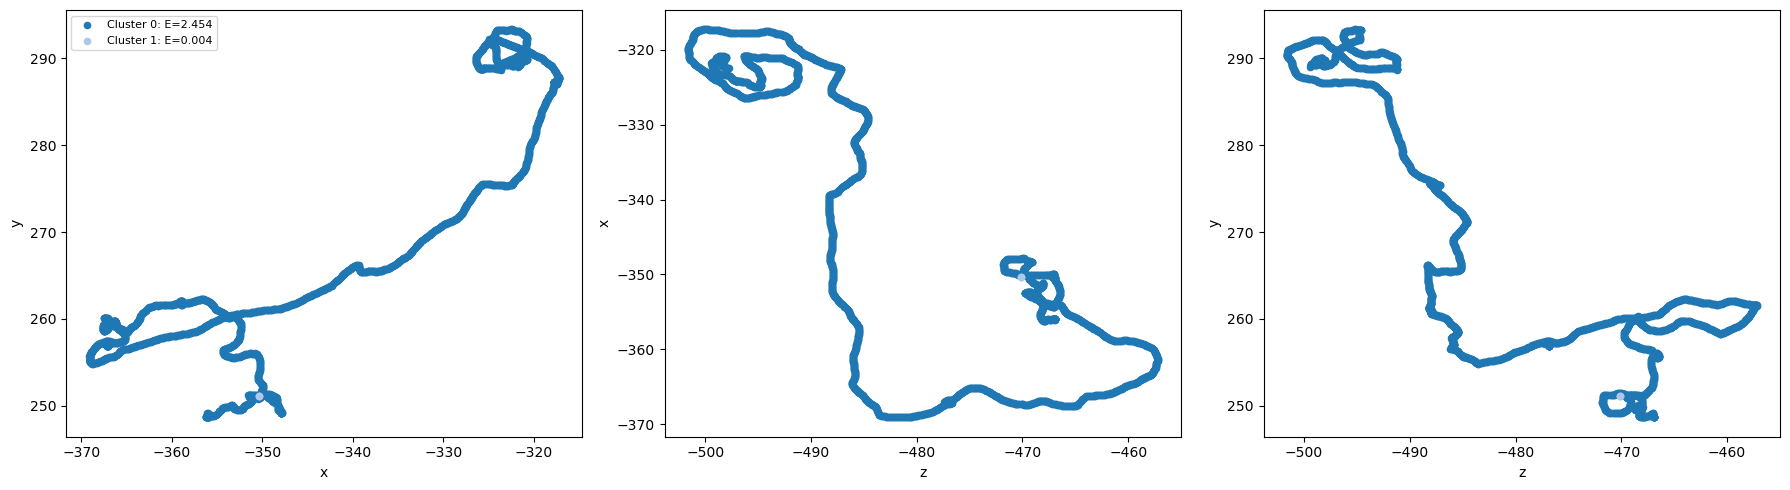

In [7]:
event_list = df_hits_epem['event_id'].unique()
ev_to_check = event_list[2]
pl.plot_clusters_with_energy(df_hits_epem[df_hits_epem['event_id'] == ev_to_check])

In [8]:
df_hits_epem_HET = sl.filter_HE_cluster(df_hits_epem)

In [9]:
shift_z = df_hits_epem_HET['z'].min()
df_hits_epem_HET['z'] = df_hits_epem_HET['z'] - shift_z

In [10]:
extremity_df_onubb = MCtp.build_extremities_df(df_hits_epem_HET)

Processing events: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.84it/s]


In [11]:
ev_to_check = event_list[18]

In [12]:
df_hits_epem_HET[df_hits_epem_HET['event_id'] == ev_to_check]

,event_id,x,y,z,time,energy,label,particle_id,hit_id
39936,18,633.331360,339.562042,1719.198486,0.000354,0.002604,0,2,0
39937,18,633.364441,339.480927,1719.151123,0.000706,0.000877,0,2,1
39938,18,633.399658,339.401581,1719.102051,0.001059,0.000666,0,2,2
39939,18,633.437439,339.321136,1719.057129,0.001412,0.000093,0,2,3
39940,18,633.479370,339.243469,1719.010864,0.001764,0.001312,0,2,4
...,...,...,...,...,...,...,...,...,...
41894,18,635.302551,321.858368,1718.344727,0.100916,0.001342,0,15,40
41895,18,635.300415,321.850311,1718.348877,0.101068,0.001724,0,15,41
41896,18,635.306396,321.850433,1718.344849,0.101196,0.005414,0,15,42
41897,18,635.308289,321.850616,1718.345215,0.101249,0.002014,0,15,43


In [13]:
p1, p2 = MCtp.find_tree_extremities(df_hits_epem_HET[df_hits_epem_HET['event_id'] == ev_to_check])

In [14]:
wval = 0.000015#w-value from https://journals.aps.org/pra/abstract/10.1103/PhysRevA.12.1771
df_hits_epem_HET = af.compute_el_ion_pairs(df_hits_epem_HET,wval)

# 0nubb ions diff analysis

In [15]:
il.reload(MCtp)
df_counts = MCtp.build_3d_counts_df(df_hits_epem_HET[df_hits_epem_HET['event_id'] == ev_to_check], diff_coeff_T, diff_coeff_L)

In [16]:
df_counts

,X,Y,Z,Q
0,622.067660,335.842556,1718.347055,1229
1,622.067660,312.622539,1718.347055,1290
2,633.677669,335.842556,1727.427740,1306
3,633.677669,335.842556,1718.347055,2161
4,645.287678,312.622539,1715.320159,1051
...,...,...,...,...
786,668.507695,289.402522,1712.293264,1
787,633.677669,289.402522,1727.427740,1
788,598.847643,277.792513,1718.347055,1
789,587.237634,312.622539,1715.320159,1


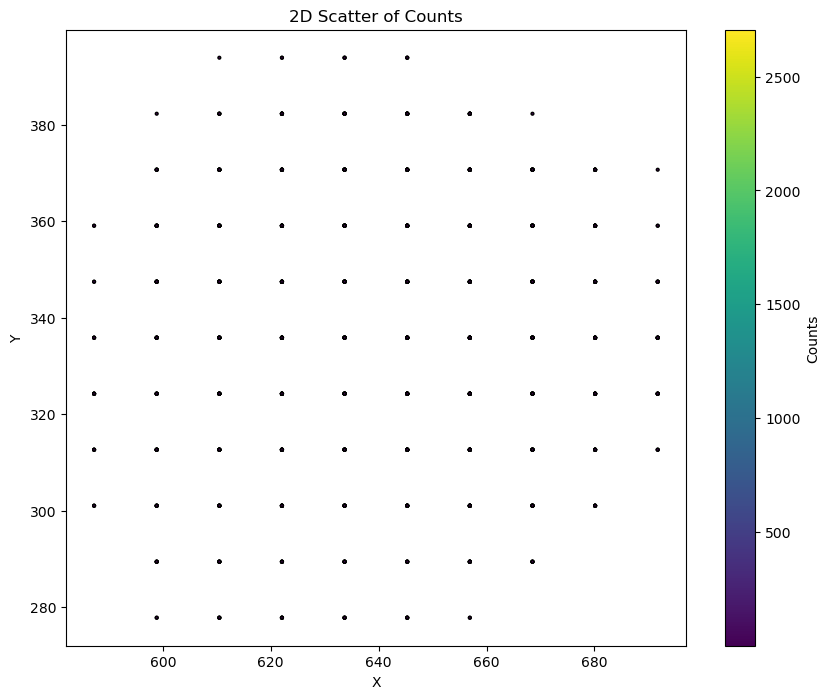

In [17]:
plt.figure(figsize=(10,8))
scatter = plt.scatter(df_counts['X'], df_counts['Y'], c=df_counts['Q'],
                      cmap='viridis', s=4, edgecolor='k')  # s is marker size

plt.colorbar(scatter, label='Counts')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Scatter of Counts')
plt.show()

In [18]:
true_p1 = extremity_df_onubb.loc[extremity_df_onubb['event_id']==ev_to_check, 'p1'].iloc[0]
true_p2 = extremity_df_onubb.loc[extremity_df_onubb['event_id']==ev_to_check, 'p2'].iloc[0]

In [19]:
dx,dy,dz = tf.compute_min_axis_spacing(df_counts)
df_counts_scaled = df_counts.copy()
df_counts_scaled['X'] = df_counts['X']/dx
df_counts_scaled['Y'] = df_counts['Y']/dy
df_counts_scaled['Z'] = df_counts['Z']/dz



In [20]:
true_p1= true_p1 / np.array([dx, dy, dz])
true_p2= true_p2 / np.array([dx, dy, dz])

# Analysis wo filter

In [46]:
plf.plot_3D_points_with_Q(df_counts_scaled, title='Original Track', true_points = (true_p1,true_p2))

In [47]:
Q_thr = 0.03*df_counts['Q'].max()
df_counts_thr = df_counts_scaled[df_counts_scaled['Q'] > Q_thr ]

In [48]:
plf.plot_3D_points_with_Q(df_counts_thr, true_points = (true_p1,true_p2) ,title='Track with threshold')

In [49]:
primary_path_points = tf.compute_primary_path_fast(df_counts_thr,100)

In [50]:
plf.plot_3D_points_with_Q(df_counts_thr, primary_path_points, true_points = (true_p1,true_p2) ,title='Track with threshold and primary path')

In [ ]:
smootherd_path = tf.reconstruct_path_ellipse(df_counts_thr, primary_path_points, ellipse_size=(2,2))

In [ ]:
plf.plot_3D_points_with_Q(df_counts_thr, smootherd_path, true_points = (true_p1,true_p2) ,title='Track with threshold and double smoothed path')

In [35]:
pt1 = smootherd_path[0]
pt2 = smootherd_path[-1] #smootherd_path[int(len(smootherd_path)/2)] 

In [36]:
print(diff_coeff_T,diff_coeff_L,df_counts['Z'].mean(),dx,dz)

sigmaxy = af.compute_sigma_tr(df_counts['Z'].mean(),diff_coeff_T)
print(sigmaxy, sigmaxy/dx)
ax1 = 5*sigmaxy/dx

sigmaz = af.compute_sigma_lon(df_counts['Z'].mean(),diff_coeff_L)
ax2 = 5*sigmaz/dz
print(sigmaz, sigmaz/dz)

print(ax1,ax2)

0.27999999999999997 0.073 1717.1760939145179 11.61000864690675 3.026895111514932
11.602870582872937 0.9993851801276897
3.025034116249016 0.9993851801277036
4.996925900638449 4.996925900638518


In [37]:
il.reload(plf)
plf.plot_3D_points_with_Q(df_counts_scaled,smootherd_path,(pt1,pt2),true_points = (true_p1,true_p2), ellipse_size=(ax2,ax1), title='Track Thresholded with point removed and smoothed path mean filtered with blobs')


# Analysis w filter

In [586]:
plf.plot_3D_points_with_Q(df_counts_scaled, title='Original Track', true_points = (true_p1,true_p2))

In [587]:
il.reload(tf)
df_counts_scaled_filt = tf.kde_gradient_filter(df_counts_scaled,kernel_size=11,bandwidth=.7,alpha=0.9)

In [588]:
plf.plot_3D_points_with_Q(df_counts_scaled_filt, title='Original Track cubic filtered', true_points = (true_p1,true_p2))

In [589]:
Q_thr = 0.03*df_counts['Q'].max()
df_counts_thr = df_counts_scaled_filt[df_counts_scaled_filt['Q'] > Q_thr ]

In [590]:
plf.plot_3D_points_with_Q(df_counts_thr, true_points = (true_p1,true_p2) ,title='Track cubic filtered with threshold')

In [591]:
primary_path_points = tf.compute_primary_path_fast(df_counts_thr,100)

In [592]:
plf.plot_3D_points_with_Q(df_counts_thr, primary_path_points, true_points = (true_p1,true_p2) ,title='Track  cubic filtered with threshold and primary path')

In [593]:
smootherd_path = tf.reconstruct_path_ellipse(df_counts_thr, primary_path_points, ellipse_size=(2,2))

In [594]:
plf.plot_3D_points_with_Q(df_counts_thr, smootherd_path, true_points = (true_p1,true_p2) ,title='Track  cubic filtered with threshold and double smoothed path')

In [595]:
pt1 = smootherd_path[0]
pt2 = smootherd_path[-1] #smootherd_path[int(len(smootherd_path)/2)] 

In [596]:
print(diff_coeff_T,diff_coeff_L,df_counts['Z'].mean(),dx,dz)

sigmaxy = af.compute_sigma_tr(df_counts['Z'].mean(),diff_coeff_T)
print(sigmaxy, sigmaxy/dx)
ax1 = 3*sigmaxy/dx

sigmaz = af.compute_sigma_lon(df_counts['Z'].mean(),diff_coeff_L)
ax2 = 3*sigmaz/dz
print(sigmaz, sigmaz/dz)

print(ax1,ax2)

0.27999999999999997 0.073 1717.3251871990353 11.61000864690675 3.026895111514932
11.603374279768982 0.9994285648409457
3.0251654372254846 0.9994285648409595
2.9982856945228367 2.998285694522878


In [597]:
il.reload(plf)
plf.plot_3D_points_with_Q(df_counts_scaled,smootherd_path,(pt1,pt2),true_points = (true_p1,true_p2), ellipse_size=(ax2,ax1), title='Track Thresholded with point removed and smoothed path mean filtered with blobs')
